https://arxiv.org/pdf/2206.03877.pdf

In [1]:
from scipy.special import kolmogi as ks
from scipy.special import kolmogorov

In [2]:
import numpy as np
import pylab as pl

In [3]:
import sys
# # sys.path.append('/global/cscratch1/sd/jianyao/ForSE/')
sys.path.append('/pscratch/sd/j/jianyao/forse_codes/') 
from forse.tools.nn_tools import *
from forse.tools.img_tools import *
from forse.tools.mix_tools import *

In [4]:
import healpy as hp
import numpy as np
import pysm3.units as u
import pysm3

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
import matplotlib.pyplot as plt

import seaborn as sns

sns.set_context("talk")
# sns.set()
sns.set_style("ticks")

In [7]:
def load_full_sky(version = 'v2', ud_grade = True):
    
    maps_3amin_Q =  hp.read_map('/pscratch/sd/j/jianyao/forse_processed_data/NN_out_Q_3amin_from_20amin_physical_units_full_sky_%s.fits'%version)
    maps_3amin_U =  hp.read_map('/pscratch/sd/j/jianyao/forse_processed_data/NN_out_U_3amin_from_20amin_physical_units_full_sky_%s.fits'%version)
    
    if ud_grade:
        maps_3amin_Q =  hp.ud_grade(maps_3amin_Q, nside_out=2048)
        maps_3amin_U =  hp.ud_grade(maps_3amin_U, nside_out=2048)
        
    maps_3amin = np.array((maps_3amin_Q, maps_3amin_U))
    del maps_3amin_Q
    del maps_3amin_U
    
    return maps_3amin

In [8]:
nnqu = hp.read_map('/global/cfs/cdirs/sobs/www/users/ForSE/fullsky_maps/forse_QU_thermaldust_12amin_2048_v0.fits', field = None)

In [9]:
my_gaussian = hp.read_map('/pscratch/sd/j/jianyao/my_dust_with_small_scales.fits', field = None)

In [10]:
my_gaussian.shape

(3, 50331648)

In [11]:
planck_mask = hp.read_map('/pscratch/sd/j/jianyao/HFI_Mask_GalPlane-apo2_2048_R2.00.fits', field = 1)
# 20, 40, 60, 70, 80, 90, 97, and 99% sky coverage; 8 masks in total

# Get small scales first!!

In [12]:
from utilities import get_small_scales

In [13]:
lmax = 2048;
nside = 2048;
comp = "IQU"
spectra_components = ["TT", "EE", "BB"]
ell_fit_high_ss = {"TT":400, "EE":400, "BB":400}  # TT always 400

In [14]:
maps_forse_12 = np.row_stack((np.ones(12*2048**2), nnqu))
ss_forse_12 = get_small_scales(maps_forse_12, lmax, spectra_components, ell_fit_high_ss, nside)

maps_forse_3_qu = load_full_sky('v2', ud_grade=True)
maps_forse_3 = np.row_stack((np.ones(12*2048**2), maps_forse_3_qu))
del maps_forse_3_qu
ss_forse_3 = get_small_scales(maps_forse_3, lmax, spectra_components, ell_fit_high_ss, nside)

In [15]:
poltens_dust = hp.read_map('/global/cfs/cdirs/cmb/www/pysm-data/dust_gnilc/gnilc_dust_template_galplanefix_nside2048.fits', field = (1,2))
poltens_dust = np.row_stack((np.ones(12*2048**2), poltens_dust))
poltens_dust <<= u.uK_RJ

poltens_dust = poltens_dust.to("uK_CMB", equivalencies=u.cmb_equivalencies(353 * u.GHz))

poltens_dust_3 = np.zeros_like(poltens_dust)
poltens_dust_3[1] = pysm3.apply_smoothing_and_coord_transform(poltens_dust[1], fwhm=3*u.arcmin) # smooth Q and U maps to 3 arcmin
poltens_dust_3[2] = pysm3.apply_smoothing_and_coord_transform(poltens_dust[2], fwhm=3*u.arcmin)


ss_poltens = get_small_scales(poltens_dust_3, lmax, spectra_components, ell_fit_high_ss, nside)
del poltens_dust

In [16]:
my_gaussian[1] = pysm3.apply_smoothing_and_coord_transform(my_gaussian[1], fwhm=3*u.arcmin)
my_gaussian[2] = pysm3.apply_smoothing_and_coord_transform(my_gaussian[2], fwhm=3*u.arcmin)
ss_gaussian = get_small_scales(my_gaussian, lmax, spectra_components, ell_fit_high_ss, nside)

In [17]:
hp.get_nside(my_gaussian)

2048

# Calculate the MFs for the small scales

In [18]:
def get_minkowsky_functionals(imap, lmax, mask = True, 
                                    sigmarange=[-3, 3], samplesize=256, 
                                    standardize= True ):
    N= imap[mask] .size 
    nside= hp.get_nside(imap) 
    sigma= imap[mask] .std() 
    imap/=sigma 
    th= pl.linspace(sigmarange[0],sigmarange[1]  , samplesize)
    _,dt,dp = hp.alm2map_der1(alm=hp.map2alm(imap,lmax=lmax) , 
                              nside=nside,lmax=lmax)
    _,dtt,dtp = hp.alm2map_der1(alm=hp.map2alm(dt,lmax=lmax) ,
                                nside=nside,lmax=lmax)
    _,dpt,dpp = hp.alm2map_der1(alm=hp.map2alm(dp,lmax=lmax) , 
                                nside=nside,lmax=lmax)
    
    V0 =pl.zeros_like(th)
    V1 =pl.zeros_like(th[1:])
    V2 =pl.zeros_like(th[1:])
    
    for i,nuj in enumerate(th)  : 
        maskTheta= imap[mask] > nuj  
        V0[i] = 1./N * imap[mask] [maskTheta].size 
        
        try : 
            maskDelta= pl.ma.masked_inside( imap[mask] , nuj, th[i+1]  ).mask  
        except IndexError: 
            continue 

        V1[i] = 1./4/N *  pl.sqrt(dp[mask][maskDelta]**2+ dt[mask][maskDelta]**2 ).sum() 
        den = dp[mask][maskDelta]**2+ dt[mask][maskDelta]**2
        num = (2*dp[mask][maskDelta] * dt[mask][maskDelta] * dpt[mask][maskDelta ] - dp[mask][maskDelta]**2 * dtt[mask][maskDelta] - 
                dt[mask][maskDelta]**2 * dpp[mask][maskDelta]) 

        V2[i] = 1./2/pl.pi/N *   (num/den).sum() 

    return th, V0,V1,V2 

In [19]:
# Q map first

def get_my_full_MFs(qmap, mask, nside, lmax, Np):
    
    Npixels = len(qmap[mask == 1])
    std = qmap[mask == 1].std()
    qmap /= std
    
    alms = hp.map2alm(qmap, lmax = lmax)
    results = hp.sphtfunc.alm2map_der1(alms, nside, lmax = lmax)
    results[2] = results[2]*np.sin(hp.pix2ang(2048, np.arange(12*2048**2))[0]) 

    alms_theta = hp.map2alm(results[1], lmax = lmax)
    theta_der_der = hp.sphtfunc.alm2map_der1(alms_theta, nside, lmax = lmax)
    theta_der_der[2] = theta_der_der[2]*np.sin(hp.pix2ang(2048, np.arange(12*2048**2))[0]) 

    alms_phi = hp.map2alm(results[2], lmax = lmax)
    phi_der_der = hp.sphtfunc.alm2map_der1(alms_phi, nside, lmax = lmax)
    phi_der_der[2] = phi_der_der[2]*np.sin(hp.pix2ang(2048, np.arange(12*2048**2))[0]) 

    rhos = np.linspace(-5, 5, Np)

    v0 = []; v1 = []; v2 = []
    
    qmap_masked = qmap[mask == 1]
    bin_index_0 = np.digitize(qmap_masked, rhos)
    
    theta_masked = results[1][mask == 1];
    phi_masked = results[2][mask == 1]; 
    theta_theta_masked = theta_der_der[1][mask == 1]
    theta_phi_masked = theta_der_der[2][mask== 1]
    phi_theta_masked = phi_der_der[1][mask== 1]
    phi_phi_masked = phi_der_der[2][mask== 1]
    
    for i in range(Np):
        v0.append(np.sum(np.heaviside(qmap_masked - rhos[i], 0))/Npixels)
        
        if i > 0:
        
            theta = theta_masked[bin_index_0 == i]
            phi  = phi_masked[bin_index_0 == i]
            theta_theta = theta_theta_masked[bin_index_0 == i]
            theta_phi = theta_phi_masked[bin_index_0 == i]
            phi_theta = phi_theta_masked[bin_index_0 == i]
            phi_phi= phi_phi_masked[bin_index_0 == i]

            v1.append(sum(np.sqrt(theta**2 + phi**2))/Npixels/4)
            v2.append(sum((2*theta*phi*phi_theta - phi**2*theta_theta - theta**2*phi_phi)/(theta**2 + phi**2))/Npixels/2/np.pi)          
    
    return rhos, v0, v1, v2

In [21]:
mask = np.arange(12*2048**2)[planck_mask == 1]
# pepe_MF = get_minkowsky_functionals(ss_forse[1], lmax, mask, sigmarange=[-5, 5], samplesize=256)

In [30]:
my_MF_12 = get_my_full_MFs(ss_forse_12[1], planck_mask, nside=2048, lmax=lmax, Np= 256)
my_MF_3 = get_my_full_MFs(ss_forse_3[1], planck_mask, nside=2048, lmax=lmax, Np= 256)

In [31]:
MF_polten_3 = get_my_full_MFs(ss_poltens[1], planck_mask, nside=2048, lmax=lmax, Np= 256)

In [32]:
MF_gaussian_3 = get_my_full_MFs(ss_gaussian[1], planck_mask, nside=2048, lmax=lmax, Np= 256)

In [28]:
pwd

'/global/u2/j/jianyao/foreground_non_gaussianity'

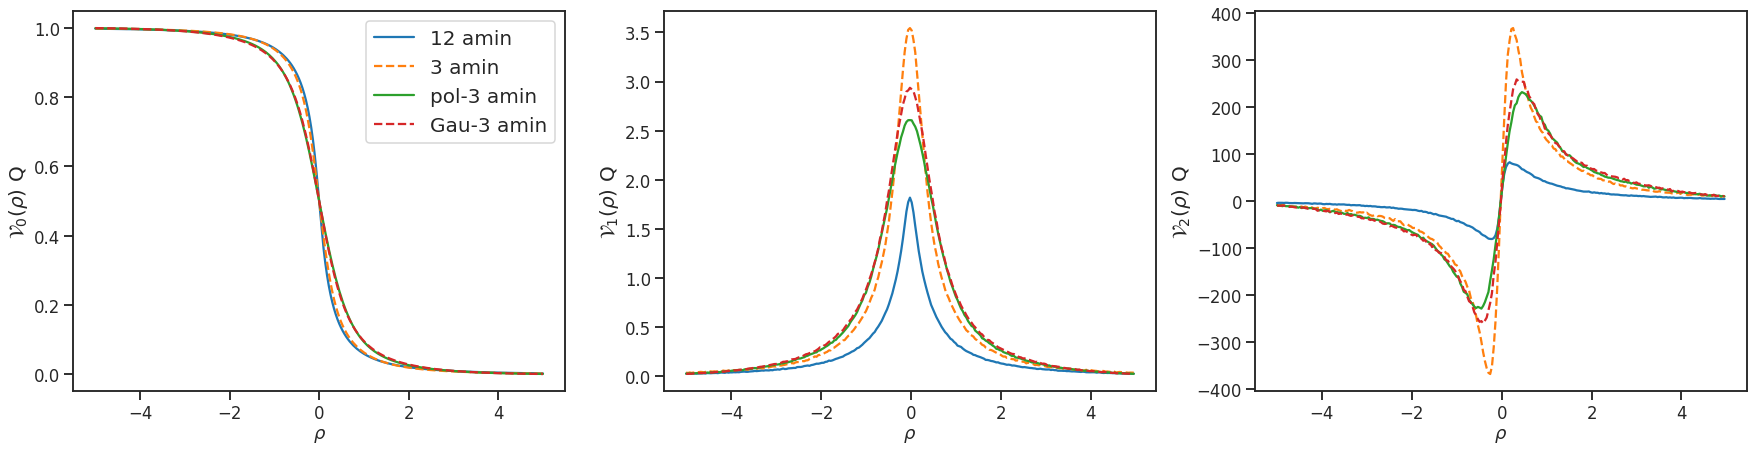

In [33]:
rhos = my_MF_12[0]
fig, axes = plt.subplots(1,3,figsize = (30, 7))
axes[0].plot(rhos, my_MF_12[1], label = '12 amin')
axes[0].plot(rhos, my_MF_3[1], '--', label = '3 amin')
axes[0].plot(rhos, MF_polten_3[1], '-', label = 'pol-3 amin')
axes[0].plot(rhos, MF_gaussian_3[1], '--', label = 'Gau-3 amin')
axes[0].legend(fontsize=20)
axes[0].set_xlabel(r'$\rho$')
axes[0].set_ylabel(r'$\mathcal{V}_0(\rho$) Q', fontsize=20)

axes[1].plot(rhos[0:-1], my_MF_12[2])
axes[1].plot(rhos[0:-1], my_MF_3[2], '--')
axes[1].plot(rhos[0:-1], MF_polten_3[2], '-')
axes[1].plot(rhos[0:-1], MF_gaussian_3[2], '--')
axes[1].set_xlabel(r'$\rho$')
axes[1].set_ylabel(r'$\mathcal{V}_1(\rho$) Q', fontsize=20)

axes[2].plot(rhos[0:-1], my_MF_12[3])
axes[2].plot(rhos[0:-1], my_MF_3[3], '--')
axes[2].plot(rhos[0:-1], MF_polten_3[3], '-')
axes[2].plot(rhos[0:-1], MF_gaussian_3[3], '--')
axes[2].set_xlabel(r'$\rho$')
axes[2].set_ylabel(r'$\mathcal{V}_2(\rho$) Q', fontsize=20)
plt.savefig('/global/homes/j/jianyao/Small_Scale_Foreground/figs/MFs_full_sky_Q.pdf', format = 'pdf')

## details

In [39]:
Np = 256; 
# rhos = np.linspace(qmap_rescaled.min(), qmap_rescaled.max(), Np)
rhos = np.linspace(-5, 5, Np)

v0 = []
for i in range(Np):
    v0.append(np.sum(np.heaviside(qmap_rescaled[mask] - rhos[i], 0))/Npixels)

## first der

In [47]:
lmax = 2048
alms = hp.map2alm(qmap_rescaled, lmax = lmax)
results = hp.sphtfunc.alm2map_der1(alms, nside =2048, lmax = lmax)

In [21]:
# results[2] = results[2]*np.sin(hp.pix2ang(2048, np.arange(12*2048**2))[0]) 

# use plt.hist function

In [64]:
v1 = []

bin_index_0 = np.digitize(qmap_rescaled[mask], rhos)
for i in range(1, Np):
    # print(i)
    # bin_index = bin_index_0 - i 
    theta = results[1][mask][bin_index_0 == i]
    phi  = results[2][mask][bin_index_0 == i]
    v1.append(sum(np.sqrt(theta**2 + phi**2))/Npixels/4)

In [65]:
v1[0]

0.006801315013108031

In [57]:
bin_index_0.shape

(8817498,)

## second der

In [69]:
thetas = results[1]
phis = results[2]

alms_theta = hp.map2alm(thetas, lmax = lmax)
theta_der_der = hp.sphtfunc.alm2map_der1(alms_theta, 2048, lmax = lmax)

alms_phi = hp.map2alm(phis, lmax = lmax)
phi_der_der = hp.sphtfunc.alm2map_der1(alms_phi, 2048, lmax = lmax)

In [70]:
v2 = []

# bin_index_0 = np.digitize(qmap_rescaled[mask], rhos)
for i in range(1, Np):
    # print(i)
    # bin_index = bin_index_0 - i 
    theta = results[1][mask][bin_index_0 == i]
    phi  = results[2][mask][bin_index_0 == i]
    theta_theta = theta_der_der[1][mask][bin_index_0 == i]
    theta_phi = theta_der_der[2][mask][bin_index_0 == i]
    phi_theta = phi_der_der[1][mask][bin_index_0 == i]
    phi_phi= phi_der_der[2][mask][bin_index_0 == i]
    
    v2.append(sum((2*theta*phi*phi_theta - phi**2*theta_theta - theta**2*phi_phi)/(theta**2 + phi**2))/Npixels/2/np.pi)